In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path

In [5]:
#ścieżki do plików
data_dir = Path("data")
sales_file = data_dir / "sales.csv"
marketing_file = data_dir / "marketing.xlsx"
currencies_file = data_dir / "currencies.json"

In [7]:
!pip install openpyxl

In [8]:
#wczytywanie danych
sales_df = pd.read_csv(sales_file,parse_dates=["date"])
marketing_df = pd.read_excel(marketing_file,parse_dates=["date"])
with open(currencies_file,"r",encoding="utf-8") as f:
    currencies_data = json.load(f)

In [9]:
#przygotowanie DataFrame z kursami walut
currencies_rows = []
for date_str,rates in currencies_data.items():
    currencies_rows.append({
        "date":pd.to_datetime(date_str),
        "USD":rates["USD"],
        "EUR":rates["EUR"]
    })
currencies_df = pd.DataFrame(currencies_rows)

In [10]:
#scalanie wszystkich danych
df = sales_df.merge(marketing_df,on=["date","country"],how="left")
df = df.merge(currencies_df,on="date",how="left")
df.head()

,date,country,sales_pln,marketing_spend_pln,USD,EUR
0,2025-01-01,Poland,12000,3000,3.95,4.25
1,2025-01-01,Germany,15000,4000,3.95,4.25
2,2025-01-01,USA,20000,5000,3.95,4.25
3,2025-02-01,Poland,18000,3500,3.90,4.20
4,2025-02-01,Germany,16000,4200,3.90,4.20


In [17]:
#kowersja sprzedaży na USD/EUR w zależności od kraju
def convert_sales(row):
    if row["country"] == "USA":
        return row["sales_pln"]/row["USD"],"USD"
    elif row["country"] == "Germany":
        return row["sales_pln"]/row["EUR"],"EUR"
    else:
        return row["sales_pln"],"PLN"
    
# df[["sales_foreign","country"]] = df.apply(lambda r:pd.Series(convert_sales(r)),axis=1)
df[["sales_foreign","currency"]] = df.apply(lambda r: pd.Series(convert_sales(r)), axis=1)

In [12]:
#Analiza NumPy: ROI(Return on Investment)
sales_arr = df["sales_pln"].to_numpy()
marketing_arr = df["marketing_spend_pln"].to_numpy()
roi_arr = (sales_arr - marketing_arr)/marketing_arr
df["ROI"] = np.round(roi_arr,2)

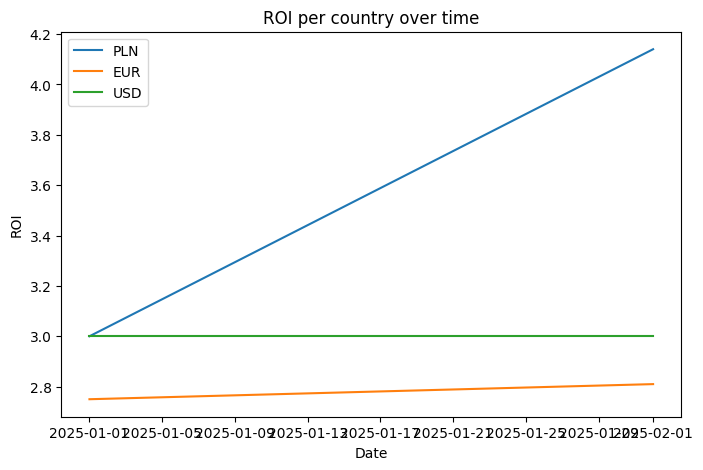

In [19]:
#wykres porównujący ROI
plt.figure(figsize=(8,5))
for c in df["country"].unique():
    subset = df[df["country"] == c]
    plt.plot(subset["date"], subset["ROI"], label=c)

plt.xlabel("Date")
plt.ylabel("ROI")
plt.title("ROI per country over time")
plt.legend()
plt.show()

In [20]:
#wyniki
print("\npełny DataFrame\n")
print(df)
print("\średni ROI dla każdego kraju")
print(df.groupby("country")["ROI"].mean().round(2))


pełny DataFrame

        date country  sales_pln  marketing_spend_pln   USD   EUR  \
0 2025-01-01     PLN      12000                 3000  3.95  4.25   
1 2025-01-01     EUR      15000                 4000  3.95  4.25   
2 2025-01-01     USD      20000                 5000  3.95  4.25   
3 2025-02-01     PLN      18000                 3500  3.90  4.20   
4 2025-02-01     EUR      16000                 4200  3.90  4.20   
5 2025-02-01     USD      22000                 5500  3.90  4.20   

   sales_foreign   ROI currency  
0          12000  3.00      PLN  
1          15000  2.75      PLN  
2          20000  3.00      PLN  
3          18000  4.14      PLN  
4          16000  2.81      PLN  
5          22000  3.00      PLN  
\średni ROI dla każdego kraju
country
EUR    2.78
PLN    3.57
USD    3.00
Name: ROI, dtype: float64
